### Table of Contents

* [Chapter 1](#chapter1) Nettoyage des données


# Importation et analyse des données

In [ ]:
# Packages courants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from pylab import figure, text, scatter, show
import os
from os import listdir
import re

# Clustering
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq

# Pipeline
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold


# Réduction de dimensions et topic modelling
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

# Métriques 
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix


# Traitement des données textuelles
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import unicodedata 
import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

## Les figures sont réalisées avec Plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from   plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_data='/content/drive/MyDrive/OC Asma - Tahri/P06/Data/'

In [ ]:
df = pd.read_csv(path_data+"Flipkart/flipkart_com-ecommerce_sample_1050.csv")
df.sample(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
595,dde89969aecfa2c5245e8059c660b139,2016-02-25 09:50:31 +0000,http://www.flipkart.com/mayursflora-bonsai-alo...,"Mayursflora Bonsai Aloe, Maple, Arecaceae, Pal...","[""Home Decor & Festive Needs >> Flowers, Plant...",ARPEDWXBWZSBKWV8,500.0,450.0,dde89969aecfa2c5245e8059c660b139.jpg,False,"Specifications of Mayursflora Bonsai Aloe, Map...",No rating available,No rating available,Mayursflora,"{""product_specification""=>[{""key""=>""Sales Pack..."
146,63bc43c0000e71eb11bfafd2f46214a4,2015-12-01 12:40:44 +0000,http://www.flipkart.com/printland-pmba1044-cer...,Printland PMBA1044 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Printland...",MUGEBFGY3ZYAPFYR,650.0,299.0,63bc43c0000e71eb11bfafd2f46214a4.jpg,False,Printland PMBA1044 Ceramic Mug (350 ml)\r\n ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."


structure de données: une ligne par photo (1050 photos) avec des informations sur chaque photo

# Analyse exploratoire

In [ ]:
df_image=df[['uniq_id','image']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Utilisation de sweetviz pour une vision globale de la base de données:

In [ ]:
!pip3 install sweetviz

     |████████████████████████████████| 15.1 MB 184 kB/s 


In [ ]:
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


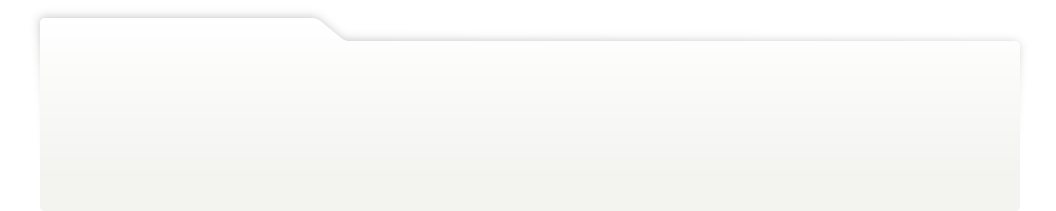
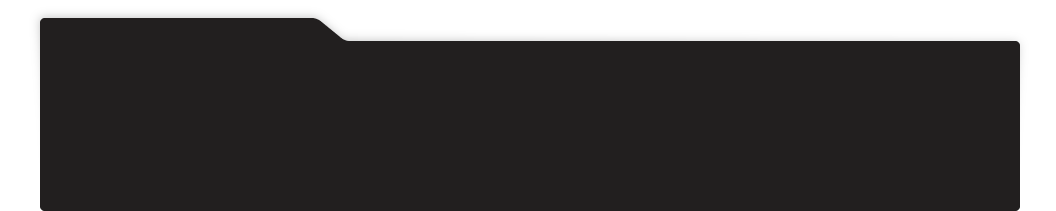
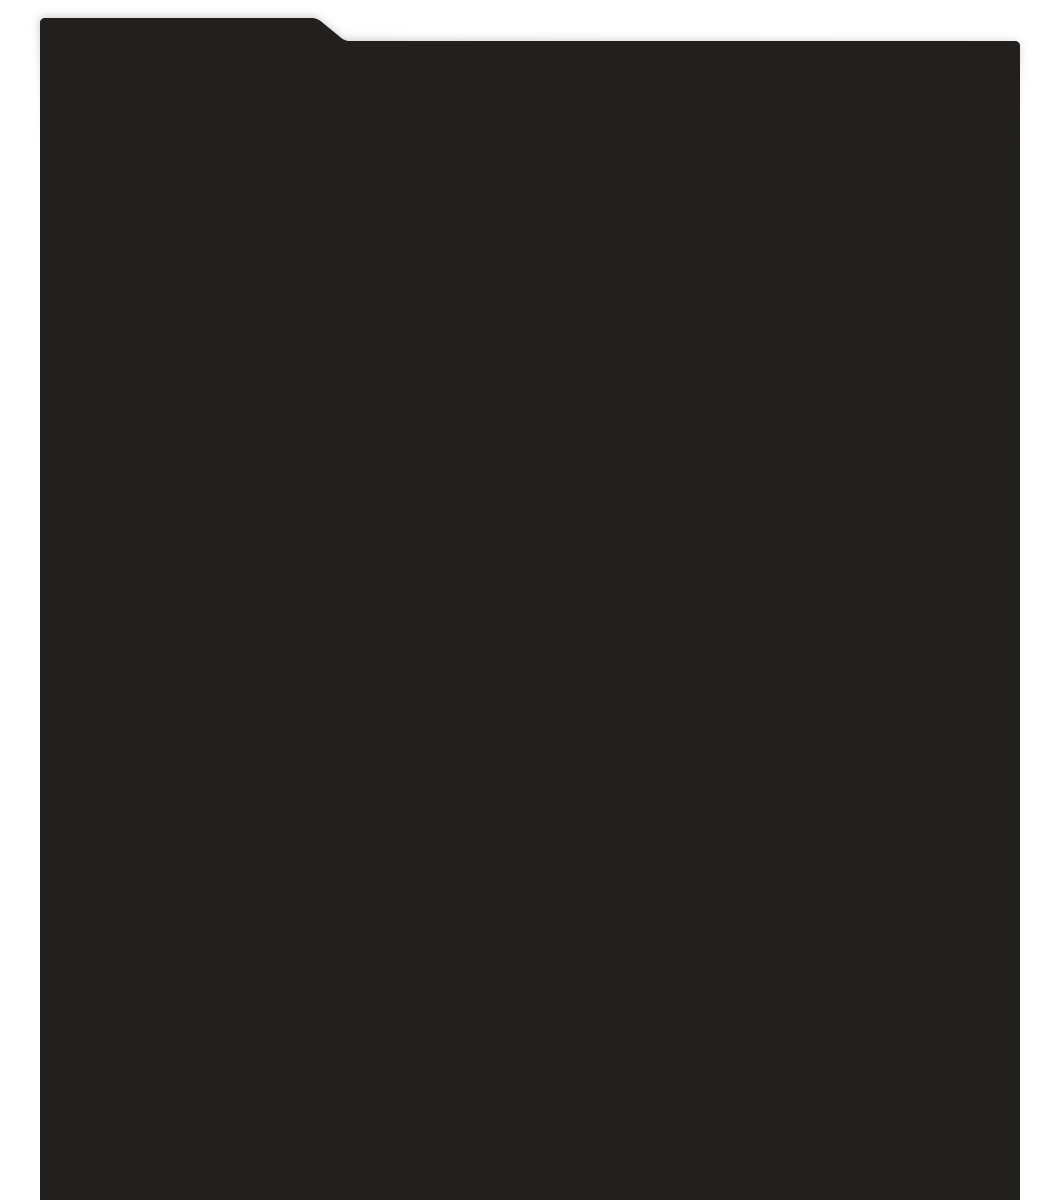
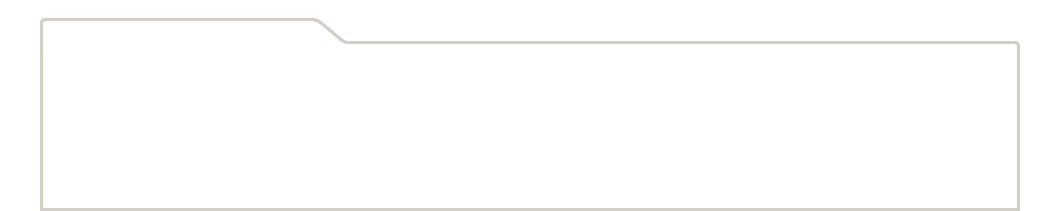
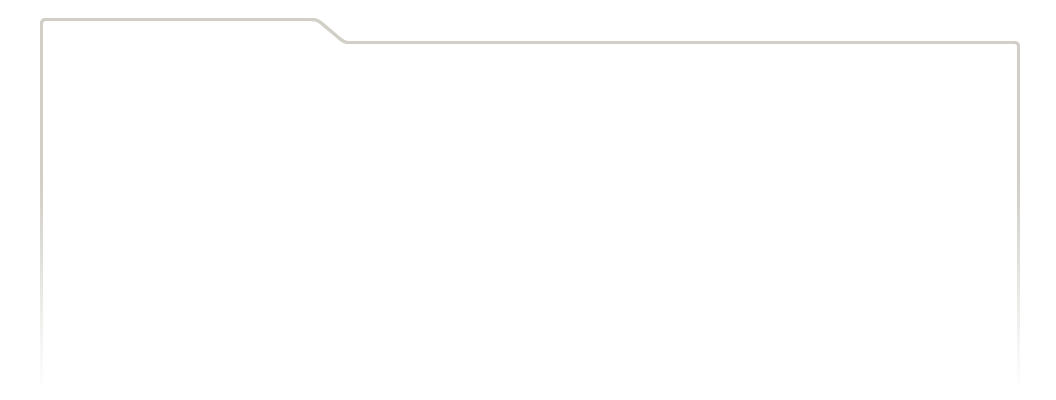
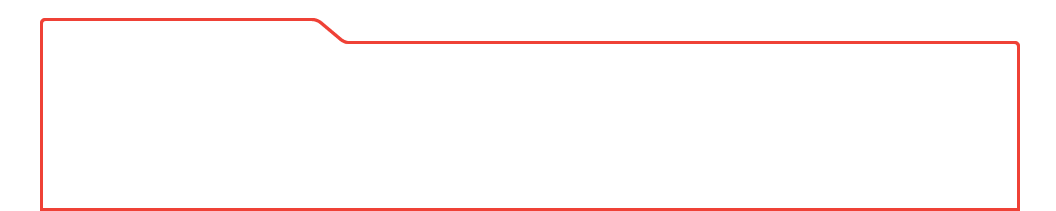
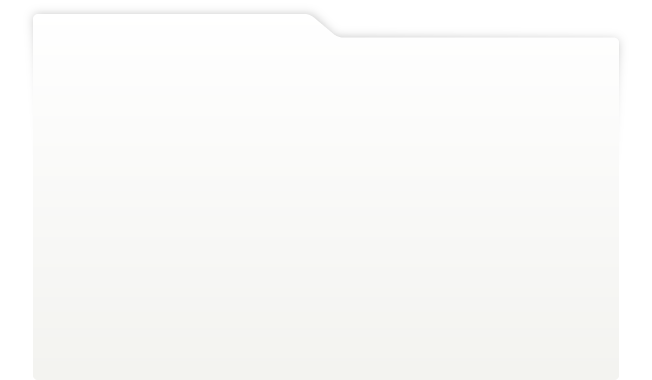
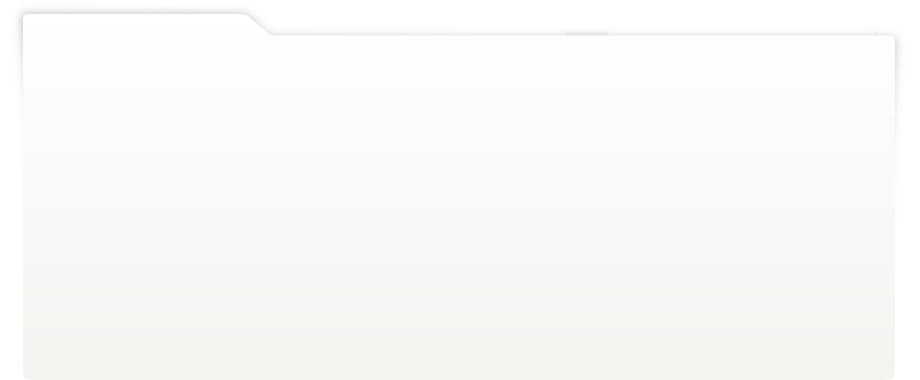
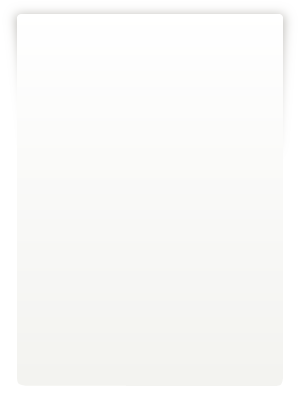
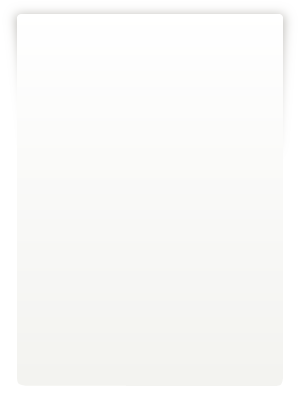
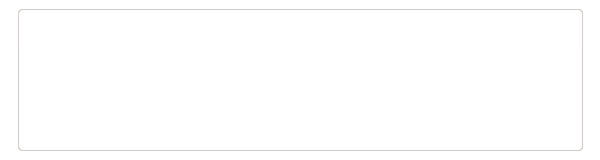
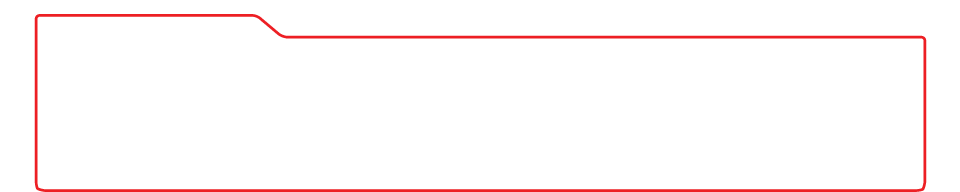
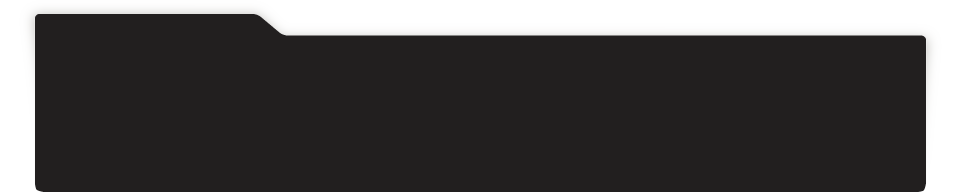
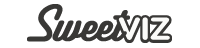
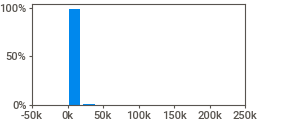
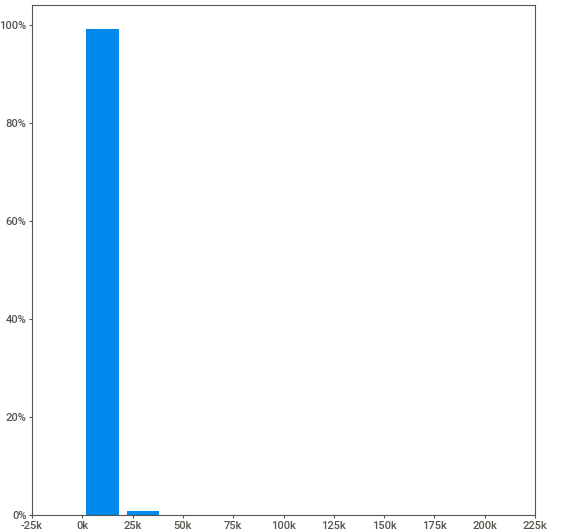
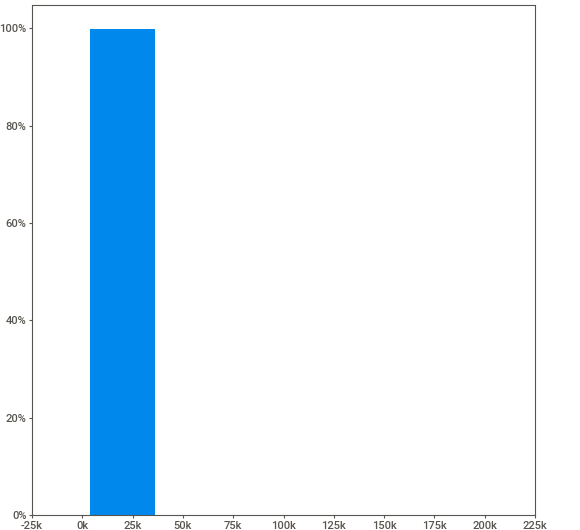
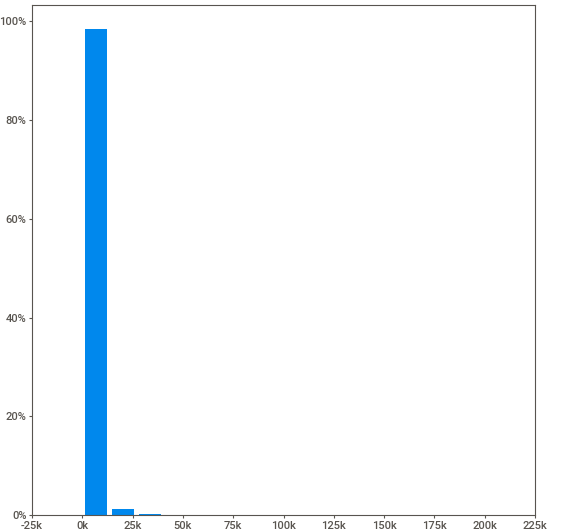
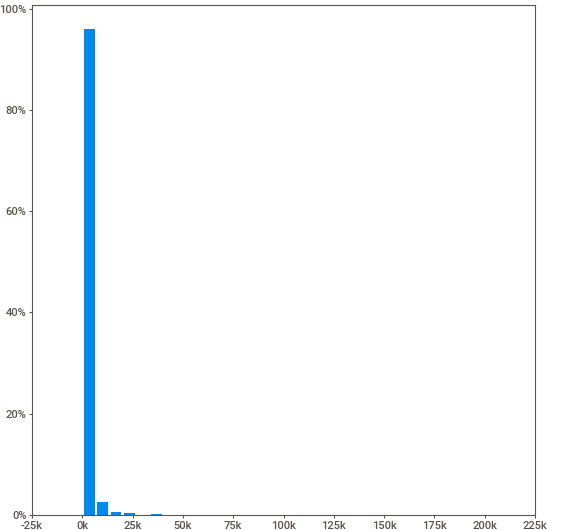
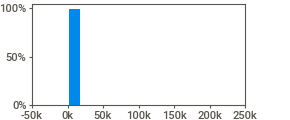
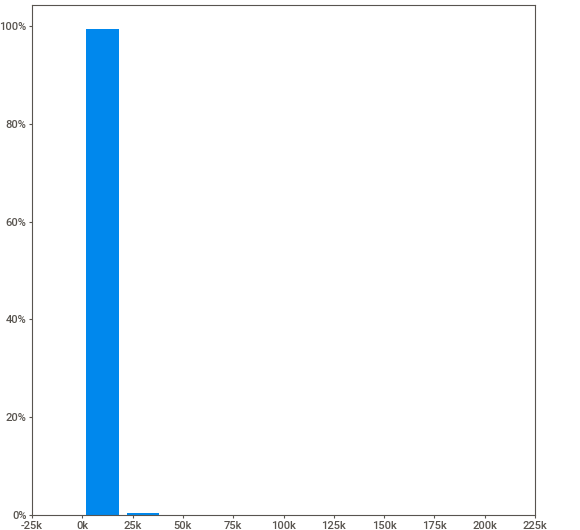
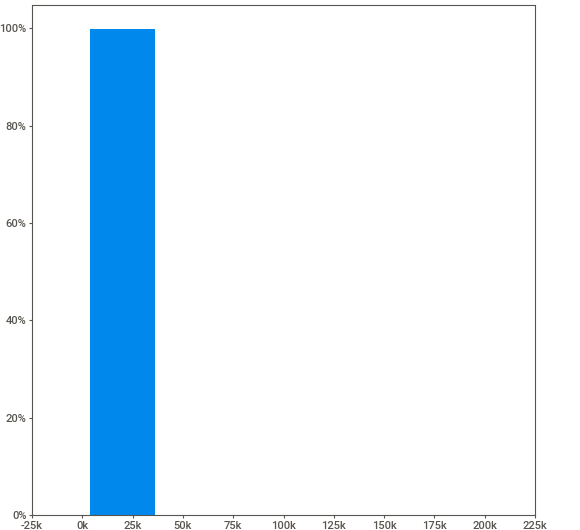
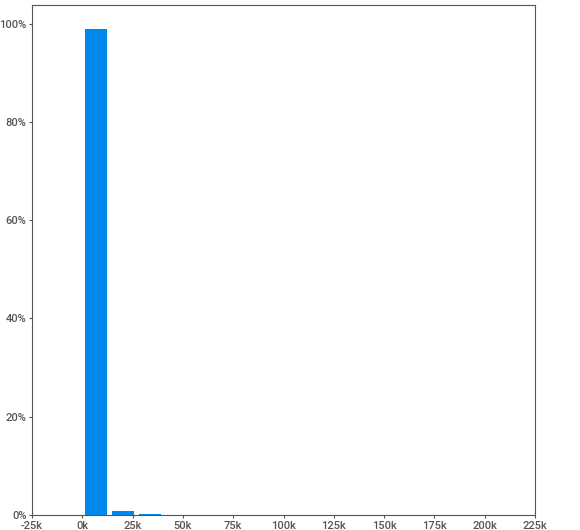
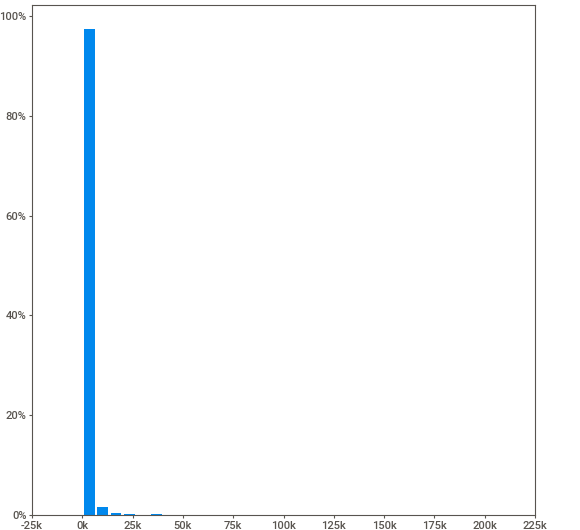
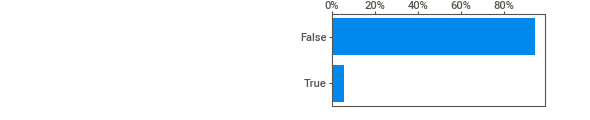
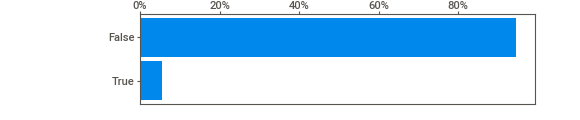
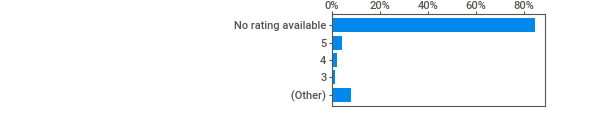
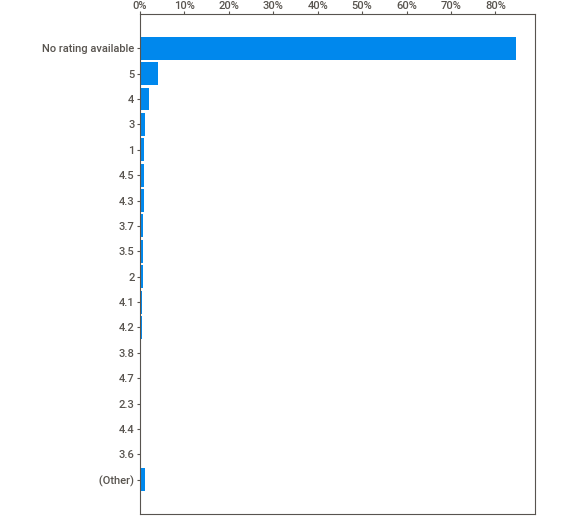
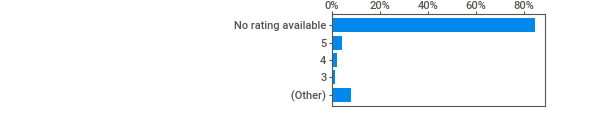
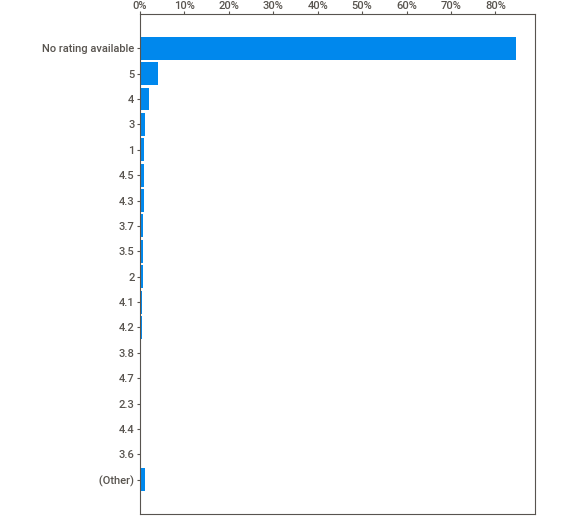
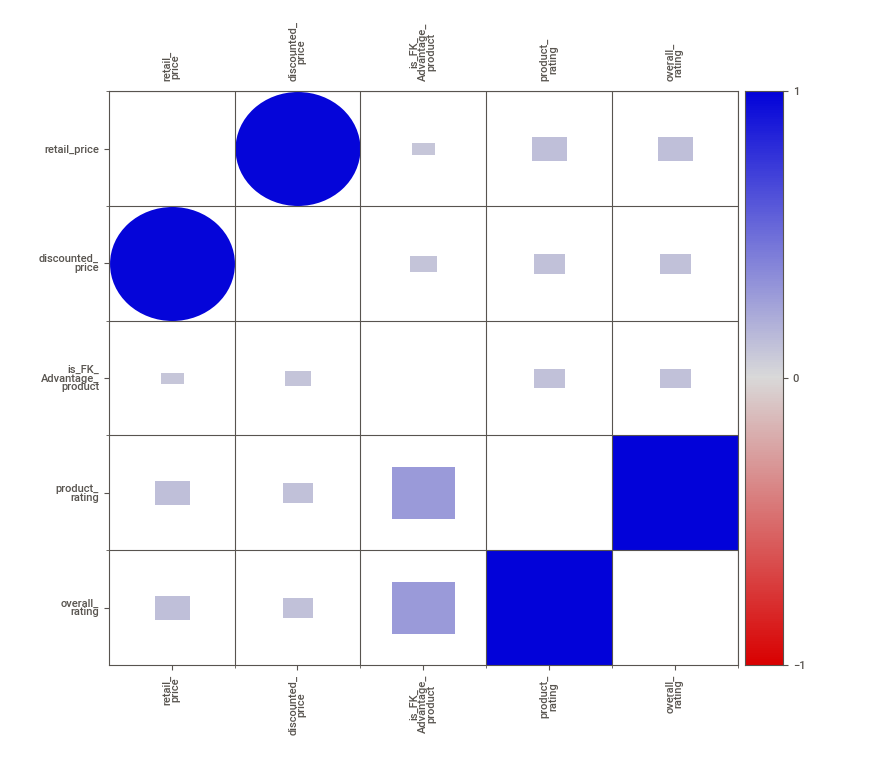
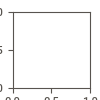

In [ ]:
my_report = sv.analyze(df)
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

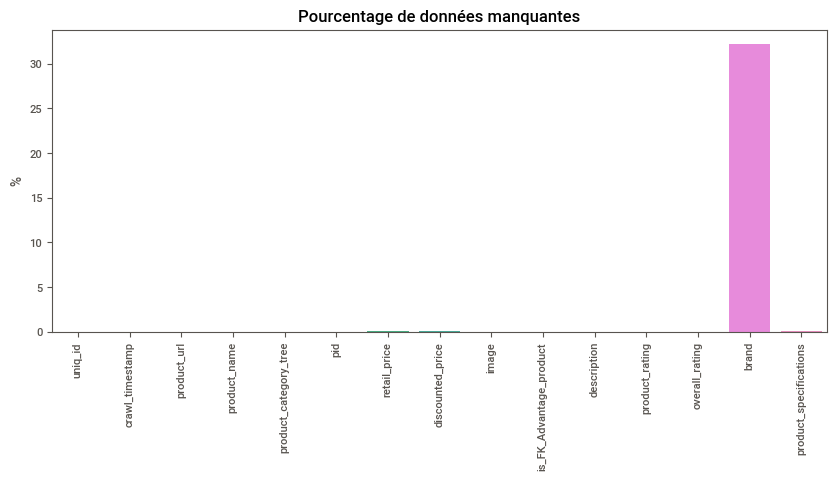

In [ ]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()


base de données globalement complète sauf pour la colonne "marque" (brand) où on a 32% des valeurs manquantes

In [ ]:
df['product_category_tree'].describe()

count                                                  1050
unique                                                  642
top       ["Home Furnishing >> Bed Linen >> Blankets, Qu...
freq                                                     56
Name: product_category_tree, dtype: object

In [ ]:
df['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

l'arbre de catégorie est composé de plusieurs branches, je vais essayer de mettre chaque branche dans une colonne

In [ ]:
# On récupère la colomne "product_category_tree"
category_list = []
for txt in df["product_category_tree"] :
    
    category_list.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
df["category"] = pd.Series(category_list)

print('Il y a {} catégories générales'.format(df['category'].nunique()))

Il y a 7 catégories générales


In [ ]:
#Répartition des scores de satisfaction:
fig= px.pie(df, names='category', title='Répartition des articles par catégorie générale')
fig.update_traces(rotation=90, pull=0.05)
fig.update_layout(width=960,height=480, legend=dict(xanchor="left", x=0.92))

nous disposons d'une distribution egale entre les 7 catégories

In [ ]:
#Nombre max de sous categorie:

s_cat = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_scat = s_cat.max()
max_scat

6

Profondeur de l'arbbre de categories est de 6

In [ ]:
# Création de 6 colonnes de catégories pour chaque photo:

def get_cat_degre(ind, scat, name_level_col):
    scat = scat.replace("[\"", "").replace("\"]", "")
    tab_str = scat.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_scat) ])
    return tup_str

In [ ]:
name_level_col = ['cat_level_'+str(i) for i in np.arange(max_scat)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: get_cat_degre(s.index, s, name_level_col))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_col, index=df.index)

In [ ]:
# Nombre de categories par niveau:
print(df_cat_level.nunique())

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64


6 niveaux dans l'arbre de catégories, avec un nombre de sous groupes qui augmonte à chaque proffodeur.( 7, 62, 243, 460, 596 et 633)

In [ ]:
#dataframe des differents niveaux de categories
df_cat_level.head()

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
0,Home Furnishing,Home Furnishing/Curtains & Accessories,Home Furnishing/Curtains & Accessories/Curtains,Home Furnishing/Curtains & Accessories/Curtain...,Home Furnishing/Curtains & Accessories/Curtain...,Home Furnishing/Curtains & Accessories/Curtain...
1,Baby Care,Baby Care/Baby Bath & Skin,Baby Care/Baby Bath & Skin/Baby Bath Towels,Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...,Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...,Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...
2,Baby Care,Baby Care/Baby Bath & Skin,Baby Care/Baby Bath & Skin/Baby Bath Towels,Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...,Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...,Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...
3,Home Furnishing,Home Furnishing/Bed Linen,Home Furnishing/Bed Linen/Bedsheets,Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...,Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...,Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...
4,Home Furnishing,Home Furnishing/Bed Linen,Home Furnishing/Bed Linen/Bedsheets,Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...,Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...,Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...


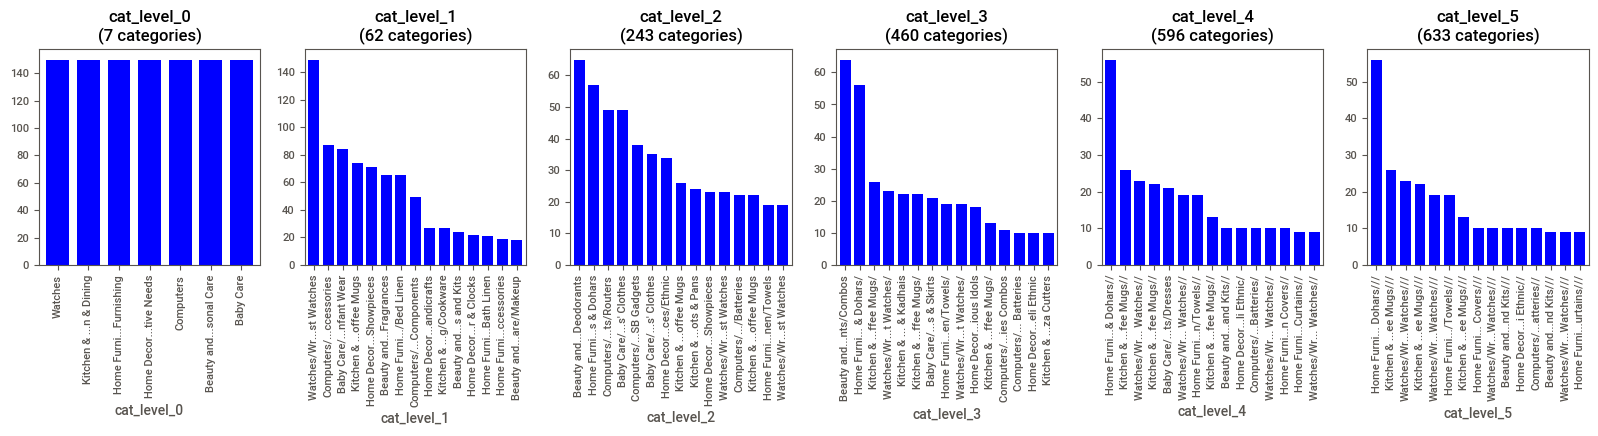

In [ ]:
# Nombre d'articles par categories pour chaque level:
shorten_label = 10
n_first = 15
fig = plt.figure(figsize=(20,20))
for i, col in enumerate(df_cat_level.columns,1):
    # plot the graphs
    ax = fig.add_subplot(6,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:n_first].plot.bar(width=0.75, color='blue', ax=ax)
    # shorten the labels
    thr = int(shorten_label)
    lab_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
    ax.axes.set_xticklabels(short_lab_x)
    # set title
    ax.set_title(col+f'\n({ser.shape[0]} categories)')

In [ ]:
#Recupération des colonnes avec du texte:
df_description = pd.concat([df_cat_level['cat_level_0'],df[["uniq_id","product_name", "description","brand"]]], axis=1)
df_description.set_index('uniq_id',inplace = True)
df_description

,cat_level_0,product_name,description,brand
uniq_id,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance
7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas
64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa
d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION
6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print
...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower
fd6cbcc22efb6b761bd564c28928483c,Baby Care,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra
5912e037d12774bb73a2048f35a00009,Baby Care,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe


In [ ]:
df_desc_image=pd.merge(df_description, df_image, on='uniq_id', how='left')
df_desc_image

,uniq_id,cat_level_0,product_name,description,brand,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,fd6cbcc22efb6b761bd564c28928483c,Baby Care,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,5912e037d12774bb73a2048f35a00009,Baby Care,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe,5912e037d12774bb73a2048f35a00009.jpg
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Baby Care,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


# NLP

## Récupération du corpus

In [ ]:
# Toute la despcription en miniscule:
df_description['description']=df_description['description'].str.lower()
df_description['product_name']=df_description['product_name'].str.lower()

#Création d'une nouvelle colonne qui regroupe la description et le titre:
df_description['desc_total']=df_description['product_name']+df_description['description']

In [ ]:
# Fonction de preprocessing des données textuelles

def tokenizer(text):
    """Tokenize a text into tokens"""
    tokenizer = nltk.RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    # American Standard Code for Information Interchange
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def no_alphabetic_removal(words):
    """Remove all tokens that are not alphabetic from list of tokenized words"""
    new_words = []
    for word in words:
        if word.isalpha():
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in nltk.corpus.stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer("english")
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

# def remove_commun_word(words):
#     """remove_commun_word"""
#     freq = pd.Series(' '.join(words).split()).value_counts()[:5]
#     new_words = []
#     for word in words:
#         if word not in freq:
#             new_words.append(word)
#     return new_words

# NN noun, singular 'desk'
# NNS noun plural 'desks'
# NNP proper noun, singular 'Harrison'
# NNPS proper noun, plural 'Americans'

def keep_nouns(words):
    """Keep only nouns words"""
    tags = nltk.pos_tag(words)
    new_words = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return new_words



def preprocessor(words):
    words = tokenizer(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = no_alphabetic_removal(words)
    words = remove_stopwords(words)
    # words = remove_commun_word(words)
    words = keep_nouns(words)
    words = stem_words(words)  
    return words

J'ai appliqué la suppression des noms commun, mais les résultats que j'ai eu étaient moins bon, donc j'ai préféré ne pas appliquer la fonction "remove_commun_word"

In [ ]:
# Exemple d'un texte avant traitement:
exemple_texte=df_description['desc_total'].iloc[1]
print('Nombre de tokens dans le test: {}'.format(len(exemple_texte)), '\n')

exemple_texte

Nombre de tokens dans le test: 470 



'sathiyas cotton bath towelspecifications of sathiyas cotton bath towel (3 bath towel, red, yellow, blue) bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm 500 model name sathiyas cotton bath towel ideal for men, women, boys, girls model id asvtwl322 color red, yellow, blue size mediam dimensions length 30 inch width 60 inch in the box number of contents in sales package 3 sales package 3 bath towel'

In [ ]:
# Validation du test
print('Nombre de tokens dans le test après traitement: {}'.format(len(preprocessor(exemple_texte))), '\n')

# for x in preprocessor(exemple_texte):
    # print(x, end=' ')
preprocessor(exemple_texte)

Nombre de tokens dans le test après traitement: 44 



['cotton',
 'bath',
 'towelspecif',
 'cotton',
 'bath',
 'towel',
 'bath',
 'towel',
 'bath',
 'towel',
 'featur',
 'machin',
 'cotton',
 'design',
 'brand',
 'sathiya',
 'type',
 'bath',
 'towel',
 'gsm',
 'model',
 'name',
 'cotton',
 'bath',
 'towel',
 'men',
 'women',
 'boy',
 'girl',
 'color',
 'blue',
 'size',
 'mediam',
 'dimens',
 'width',
 'inch',
 'box',
 'number',
 'content',
 'sale',
 'packag',
 'sale',
 'bath',
 'towel']

In [ ]:
# # le nombre totale des mots du corpus sans traitemant:
# corpus = ' '.join(df_description['desc_total'].values)
# len(corpus.split())

In [ ]:
# tokenizer = nltk.RegexpTokenizer(r'\w+')
# corpus=tokenizer.tokenize(corpus)

In [ ]:
# english_sw = nltk.corpus.stopwords.words('english')
# sw = list(set(english_sw ))

In [ ]:
from nltk.stem.snowball import EnglishStemmer


In [ ]:
# def tokenize_clean(document, stopwords,lemmatizer):
#     # 1 - tokenizing the words in each description
#     tokenizer = nltk.RegexpTokenizer(r'[A-Za-z]+')
#     list_words = tokenizer.tokenize(document)
    
    
#     # 4 - lemmatizing or stemming
#     if lemmatizer is not None:
#         lem_doc = lemmatizer(' '.join(list_words))
#         list_words = [token.lemma_ for token in lem_doc]
    
#     # 5 - removing stopwords
#     list_words = [s for s in list_words if s not in stopwords]

#     return list_words

In [ ]:
# Application du traitement du texte sur l'ensemble des description ==> nouvelle colonne 'desc_clean' du description totale traitée:
df_description['desc_clean'] = df_description['desc_total'].apply(preprocessor)

In [ ]:
df_description

,cat_level_0,product_name,description,brand,desc_total,desc_clean
uniq_id,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,elegance polyester multicolor abstract eyelet ...,key features of elegance polyester multicolor ...,Elegance,elegance polyester multicolor abstract eyelet ...,"[eleg, polyest, multicolor, eyelet, door, curt..."
7b72c92c2f6c40268628ec5f14c6d590,Baby Care,sathiyas cotton bath towel,specifications of sathiyas cotton bath towel (...,Sathiyas,sathiyas cotton bath towelspecifications of sa...,"[cotton, bath, towelspecif, cotton, bath, towe..."
64d5d4a258243731dc7bbb1eef49ad74,Baby Care,eurospa cotton terry face towel set,key features of eurospa cotton terry face towe...,Eurospa,eurospa cotton terry face towel setkey feature...,"[cotton, terri, face, towel, setkey, cotton, t..."
d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,santosh royal fashion cotton printed king size...,key features of santosh royal fashion cotton p...,SANTOSH ROYAL FASHION,santosh royal fashion cotton printed king size...,"[fashion, cotton, bedsheetkey, featur, fashion..."
6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,jaipur print cotton floral king sized double b...,key features of jaipur print cotton floral kin...,Jaipur Print,jaipur print cotton floral king sized double b...,"[jaipur, print, cotton, king, bedsheetkey, fea..."
...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,oren empower extra large self adhesive sticker,oren empower extra large self adhesive sticker...,Oren Empower,oren empower extra large self adhesive sticker...,"[oren, self, stickeroren, empow, self, sticker..."
fd6cbcc22efb6b761bd564c28928483c,Baby Care,wallmantra large vinyl sticker sticker,wallmantra large vinyl sticker sticker (pack o...,Wallmantra,wallmantra large vinyl sticker stickerwallmant...,"[vinyl, sticker, vinyl, sticker, sticker, pack..."
5912e037d12774bb73a2048f35a00009,Baby Care,uberlyfe extra large pigmented polyvinyl films...,buy uberlyfe extra large pigmented polyvinyl f...,Uberlyfe,uberlyfe extra large pigmented polyvinyl films...,"[polyvinyl, film, polyvinyl, film, sticker, rs..."


Mantenant que nous avons un corpus nettoyé, nous allons essayer d'appliquer quelques méthodes pour choisir *celle qui nous donne le meillieur résultat: 

### Bag Of Words

Le bag-of-words consiste à créer une colonne pour chaque mot différent présent pour l'ensemble des textes et d'indiquer le nombre de fois qu'il apparait dans chaque texte. L'histogramme associé consiste à indiquer la fréquence normalisé de l'apparition de chacun des mots dans chaque texte pour l'ensemble du corpus de textes.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Vectorisation
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df_description['desc_clean'].astype('U'))
tokens = bow_vectorizer.get_feature_names()
df_bow = pd.DataFrame(bow.toarray(), columns=tokens)
df_bow.head(3)

,aa,aapno,aari,abil,abod,abras,absolut,absorb,abstract,abstrct,abuy,ac,accent,access,accessori,accid,accomplish,acer,ach,acid,act,adaa,adapt,adapterkey,adapterlapguard,adapterspecif,adaptor,add,addict,addit,adi,adida,adino,adjust,admir,adsl,advanc,advic,aero,affect,...,wool,word,work,workmanship,workstat,world,worri,worshipp,wow,wrap,wrapper,wrinkl,wrist,xl,xp,xyz,yardley,year,yellow,yellowkey,yes,ygs,yiboo,yield,yk,york,youth,yuva,yves,zaicus,zero,zikrak,zinc,zingalalaa,zip,zipper,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


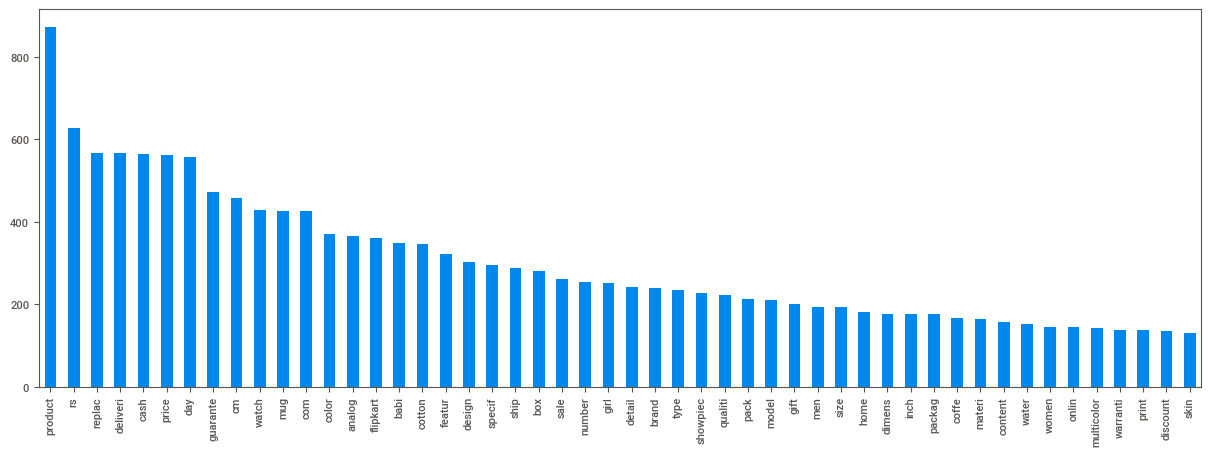

In [ ]:
# 50 Termes les plus fréquents dans l'ensemble des descriptions
df_bow.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

Le terme le plus fréquent est 'product' qui se repète 850 fois dans l'ensemble du corpus.

(1050, 119)


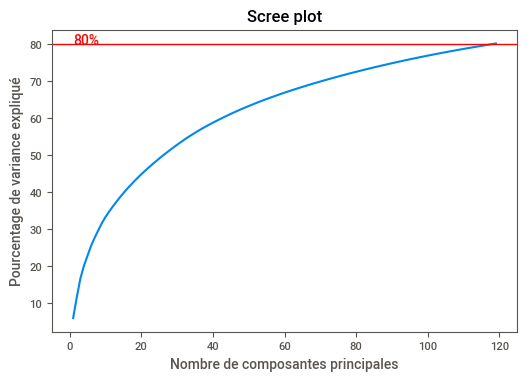

In [ ]:
# Réduction PCA, 80% de variance expliqué 
pca = PCA(n_components=0.8, random_state=22)
pca.fit(df_bow)
x = pca.transform(df_bow)
print(x.shape)

# Scree plot
scree = pca.explained_variance_ratio_*100
plt.plot(np.arange(len(scree))+1, scree.cumsum()) #,c="red",marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Pourcentage de variance expliqué")
plt.axhline(80, lw=1, c='red')
plt.text(1, 80, '80%', c='red')
plt.title("Scree plot")
plt.show(block=False)

# Réduction t-SNE
dict_tsne_results = {}
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
tsne_results = tsne.fit_transform(x)
dict_tsne_results['text_BOW']=tsne_results

Pour un seuil de 80% de variance expliquée, nous avons besoin de 119 composantes principales.

In [ ]:
# Clustering
kmeans = KMeans(n_clusters=df_description['cat_level_0'].nunique(),n_jobs=-1, random_state=22)
kmeans.fit(tsne_results)            
y_pred =  kmeans.labels_
dict_y_pred = {}
dict_y_pred['text_BOW'] = y_pred

In [ ]:
def visualisation(tsne_results, y_pred):    
    # Visualisation 2D de y_pred et y_true
    fig = plt.figure(1, figsize=(20, 8))
    plt.suptitle("Visualisation des clusters", fontsize=25, fontweight='bold')

    # Plot 1
    plt.subplot(1, 2, 1)

    X_normalized = MinMaxScaler().fit_transform(tsne_results)
    y_true =  df_description['cat_level_0'].values

    cmap = plt.cm.get_cmap("jet")
    digits = np.unique(y_true)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y_true == digit, 0],
                        X_normalized[y_true == digit, 1],
                        c=[cmap(i / 7)],
                        label=digit)

    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.title("y_true", fontsize=15)

    # Plot 2
    plt.subplot(1, 2, 2)

    cmap = plt.cm.get_cmap("jet")
    digits = np.unique(y_pred)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y_pred == digit, 0],
                        X_normalized[y_pred == digit, 1],
                        c=[cmap(i / 7)],
                        label=digit)

    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.title("y_pred", fontsize=15)

    plt.show()

    result = adjusted_rand_score(df_description['cat_level_0'], kmeans.labels_)
    print('ARI = {}'.format(result))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

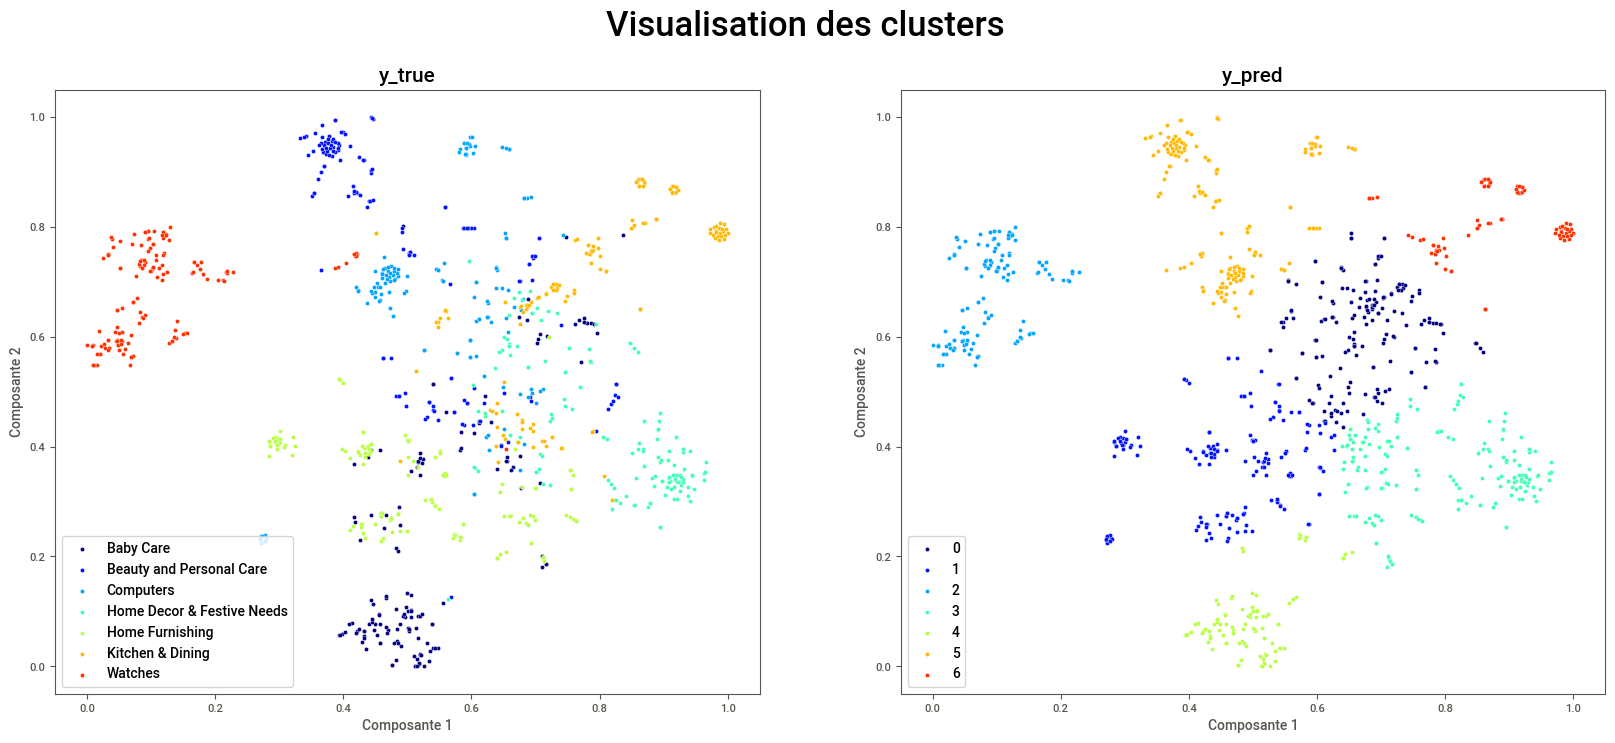

ARI = 0.383945370223066


In [ ]:
# Affichage de la segmentation réelle et la segmentation prédite avec la methode BoW, plus de coef ARI:
visualisation(tsne_results, y_pred)

La segmentation prédite avec la méthode BoW est assez différente de la segmentation réelle, sur la premire composante principale.
le coef ARI est de 0.38, nous allons essayer d'améliorer en utilisant d'autres méthodes

### Tf-idf

Avec le tf-idf (Term-Frequency - Inverse Document Frequency), nous utilisons un poids par terme, (au lieu de la fréquence avec le BoW), ce poids est calculé en multipliant la fréquence par document fois l'inverse de la proportion de document qui contient le terme, à l'echelle logarithmique.

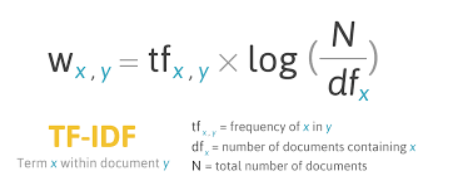

In [ ]:
# Vectorisation
tfidfvectorizer = TfidfVectorizer(max_features=800,
                                  min_df=5,
                                  max_df=0.7,
                                  stop_words=nltk.corpus.stopwords.words(
                                      'english'),
                                  tokenizer=preprocessor,
                                  token_pattern='[a-zA-Z0-9]{3,}')

In [ ]:
# Dataframe sous forme TF-IDF
TF_IDF_array = tfidfvectorizer.fit_transform(df_description['desc_clean'].astype('U'))
tokens = tfidfvectorizer.get_feature_names()
TF_IDF_df = pd.DataFrame(TF_IDF_array.toarray(), columns=tokens)
print(TF_IDF_df.shape)
TF_IDF_df.sample(3)

(1050, 482)


,abstract,ac,accessori,adapt,adapterkey,addit,age,air,akup,almond,aloevera,aluminium,analog,apparel,appl,area,aroma,art,artist,asus,authent,babi,bag,band,bank,base,bath,batteri,beauti,bed,bedroom,bedsheet,bedsheetkey,birthday,blanket,bleach,blue,bodi,bodysuit,bottl,...,trendnet,tv,type,use,v,vaio,vaniti,varieti,velvet,vgn,video,vinyl,vitamin,volateg,voltag,volum,w,wall,wardrob,warranti,wash,watch,watchsonata,water,waterproof,way,wheel,width,window,wireless,women,womenmaxima,womensonata,wood,work,world,wrap,x,year,yes
945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.741577,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.648448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


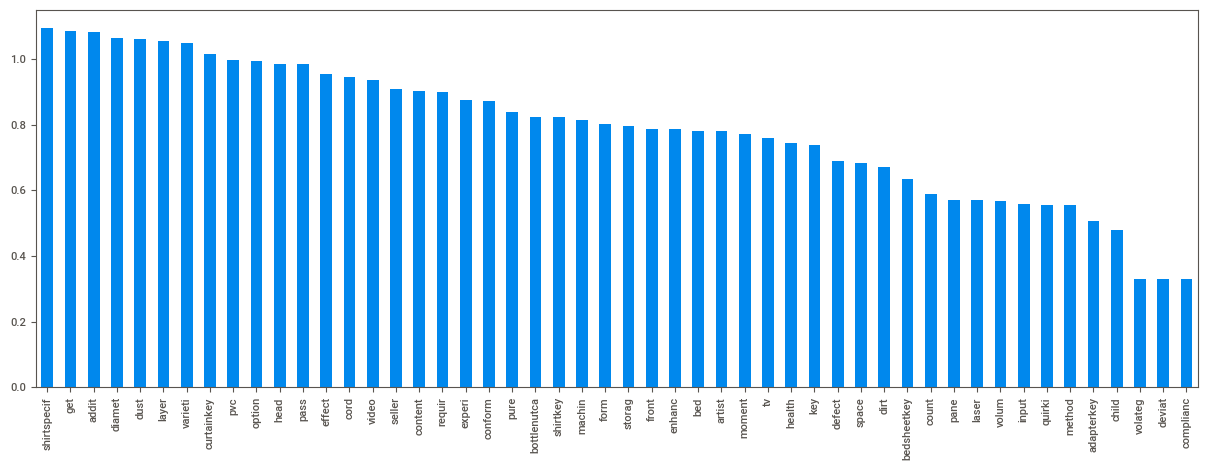

In [ ]:
# 50 termes avec les poids les plus faibles:
TF_IDF_df.sum(axis=0).sort_values(ascending=False)[-50:].plot.bar(figsize=(15,5))
plt.show()

le terme 'complianc' a le plus faible poids dans l'ensemble des description comme nous montre cette présentation des 50 termes avec les poids les plus faibles

(1050, 118)


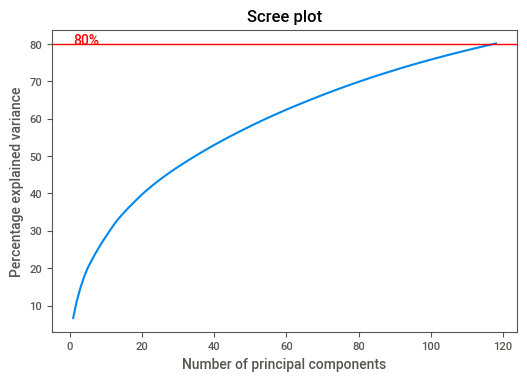

In [ ]:
# Réduction PCA, 80% de variance expliqué 
pca = PCA(n_components=0.8, random_state=22)
pca.fit(TF_IDF_df)
x = pca.transform(TF_IDF_df)
print(x.shape)

# Scree plot
scree = pca.explained_variance_ratio_*100
plt.plot(np.arange(len(scree))+1, scree.cumsum()) #,c="red",marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.axhline(80, lw=1, c='red')
plt.text(1, 80, '80%', c='red')
plt.title("Scree plot")
plt.show(block=False)

# Réduction t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
tsne_results = tsne.fit_transform(x)
dict_tsne_results['text_TF_IDF']=tsne_results

Pour avoir une variance expliquée à 80% nous avons besoin de 118 composantes principales

In [ ]:
# Clustering
kmeans = KMeans(n_clusters=df_description['cat_level_0'].nunique(),n_jobs=-1, random_state=22)
kmeans.fit(tsne_results)            
y_pred =  kmeans.labels_
dict_y_pred = {}
dict_y_pred['text_TF_IDF'] = y_pred

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

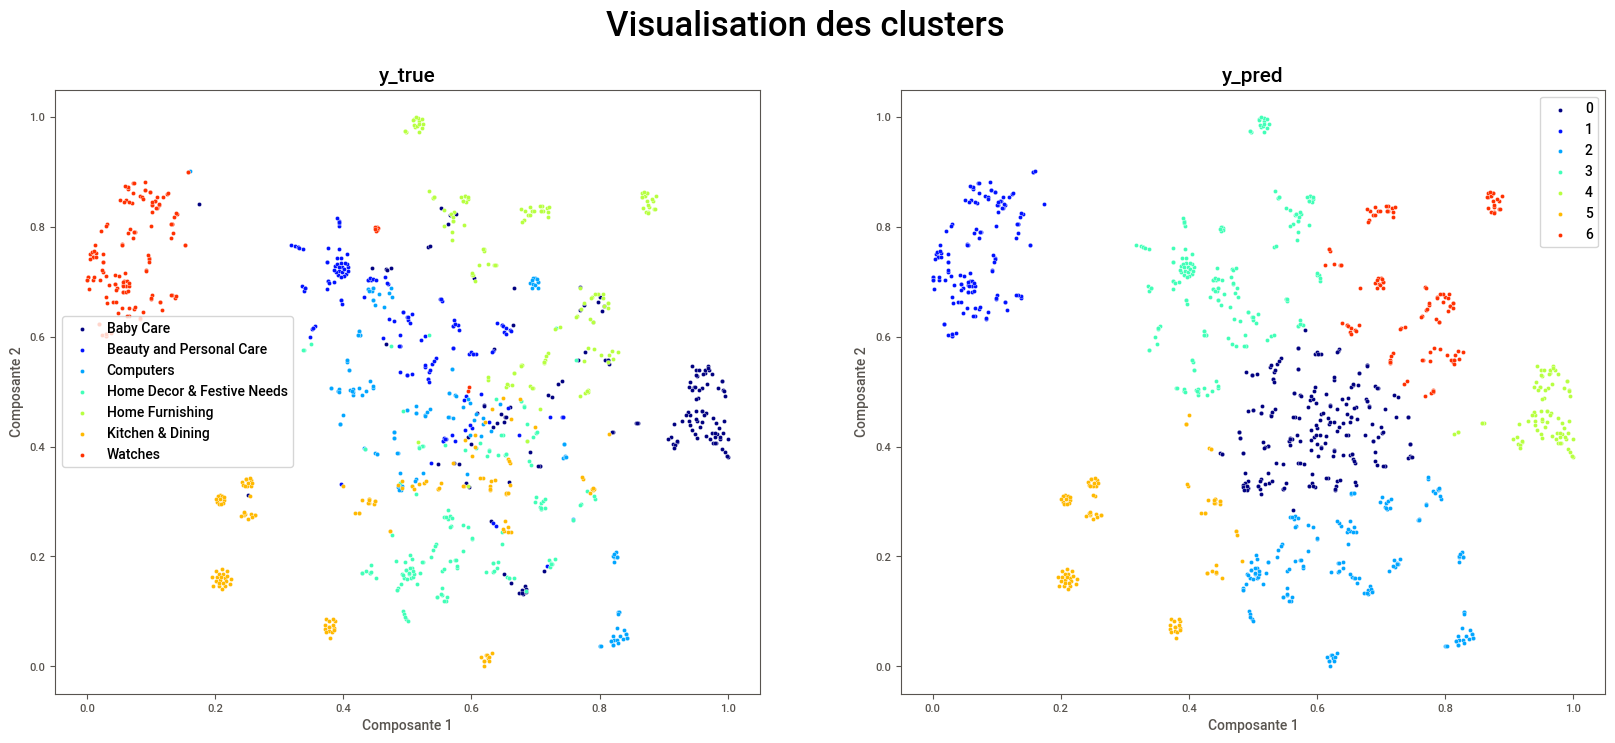

ARI = 0.35172411451458835


In [ ]:
#Présetation graphique du clusturisation obtenue avec la méthode Tf-idf, comparée à la segmantation réelle et le coef ARI: 
visualisation(tsne_results, y_pred)

Nous obtenons un Coeficient ARI de 0,35, c'est moins bien que ce qu'on a eu avec la méthode BoW. 

Nous allons essayer d'avoir mieux avec la méthode LDA:

### BoW + LDA

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
# Modèle LDA
lda = LatentDirichletAllocation(n_components=df_description['cat_level_0'].nunique())

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
bow_lda_pipeline = Pipeline(steps=[('BOW', bow_vectorizer),('lda', lda),])

In [ ]:
bow_lda_pipeline

Pipeline(memory=None,
         steps=[('BOW',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lda',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='batch',
                                      

In [ ]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wall

In [ ]:
LDA_array = bow_lda_pipeline.fit_transform(df['product_name'].astype('U'))
print(LDA_array.shape)
LDA_array

(1050, 7)


array([[0.01785718, 0.01786956, 0.01785717, ..., 0.68228376, 0.01785717,
        0.22841505],
       [0.02857507, 0.02857153, 0.24359777, ..., 0.02857156, 0.02857164,
        0.61353793],
       [0.17013374, 0.16482291, 0.1680293 , ..., 0.02040836, 0.16639182,
        0.28978589],
       ...,
       [0.01587318, 0.01587308, 0.01587312, ..., 0.45990483, 0.01587315,
        0.46072953],
       [0.19043882, 0.02380954, 0.02380955, ..., 0.02380954, 0.02380955,
        0.69047982],
       [0.0285715 , 0.02857144, 0.02857145, ..., 0.02857145, 0.02857146,
        0.82857125]])

In [ ]:
# Vectorisation
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df_description['desc_clean'].astype('U'))
tokens = bow_vectorizer.get_feature_names()
df_bow = pd.DataFrame(bow.toarray(), columns=tokens)
df_bow.head(3)

,aa,aapno,aari,abil,abod,abras,absolut,absorb,abstract,abstrct,abuy,ac,accent,access,accessori,accid,accomplish,acer,ach,acid,act,adaa,adapt,adapterkey,adapterlapguard,adapterspecif,adaptor,add,addict,addit,adi,adida,adino,adjust,admir,adsl,advanc,advic,aero,affect,...,wool,word,work,workmanship,workstat,world,worri,worshipp,wow,wrap,wrapper,wrinkl,wrist,xl,xp,xyz,yardley,year,yellow,yellowkey,yes,ygs,yiboo,yield,yk,york,youth,yuva,yves,zaicus,zero,zikrak,zinc,zingalalaa,zip,zipper,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Définition des topics
# cv = bow_vectorizer.fit_transform(df_description['description'].values.astype('U'))
lda.fit(bow)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
top_words = 10
# tf_feature_names = bow_vectorizer.get_feature_names()
display_topics(lda, tokens, top_words)

Topic 0:
mug specif featur product design gift size rs day price
Topic 1:
home wall decor sticker price showpiec inch brass rs art
Topic 2:
skin print shape pad mous inch combo price product warranti
Topic 3:
watch analog replac product com day deliveri cash guarante mug
Topic 4:
cm color box design model number sale featur packag brand
Topic 5:
product deliveri cash replac day guarante price rs showpiec com
Topic 6:
babi cotton girl detail boy towel neck dress number content


In [ ]:
dict_tsne_results = {}

# Réduction t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
tsne_results = tsne.fit_transform(LDA_array)
dict_tsne_results['text_LDA']=tsne_results

In [ ]:
# Clustering
kmeans = KMeans(n_clusters=df_description['cat_level_0'].nunique(),n_jobs=-1, random_state=22)
kmeans.fit(tsne_results)            
y_pred =  kmeans.labels_
dict_y_pred['text_LDA'] = y_pred

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

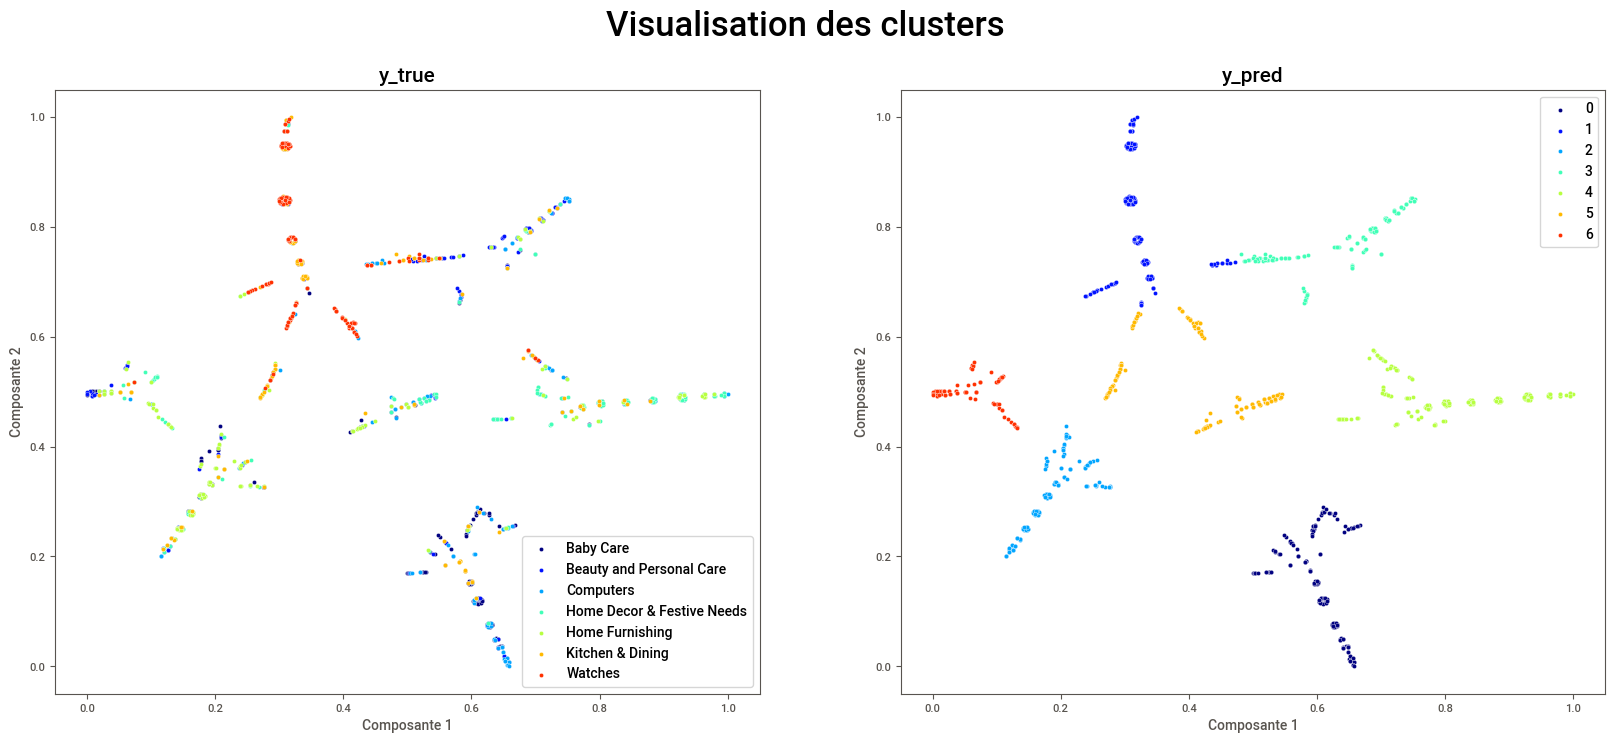

ARI = 0.14501225437212362


In [ ]:
visualisation(tsne_results, y_pred)

La classification obtenue avec la méthode LDA est encore moins bien que les deux méthodes precedentes, en effet le coef ARI est de 0.14.

Nous allons voir ci on va avoir une meilleure classification en se basant sur les données visuelles dans le notebook_02.

In [ ]:
# Sauvegarder les données:
df_desc_image.to_csv(path_data+"df_desc_image.csv")